In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tsa import stattools
from statsmodels.tsa.statespace.tools import diff
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
# explicitly require this experimental feature to enable HalvingCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from scipy.stats import randint, uniform, loguniform

from argparse import Namespace
plt.style.use('seaborn')

# After updating the Namespace arguments right below, please run all the cells to run this Notebook

In [78]:
# REQUIRES UPDATING THE FOLLOWING ARGUMENTS USED FOR GLOBAL VARIABLE
""" 
(NOTE) All the path variables require specifying file name and extension; e.g., 'PATH/pred.csv'
"""
args = Namespace(mkt_path = "./market_data.csv",
                date_path = "./dates_info.csv",
                output_path = "./pred.csv",
                mkt_hold_out_path = "./market_data_ho.csv",
                date_hold_out_path = "./dates_info_ho.csv",
                train_epoch = 100)

In [79]:
def main():
    
    """
    Main Function that will read and preprocess 'dates' and 'mkt' tables
    Models (OLS, Random Forest, XGBoost) will be trained using the entire 'mkt' and 'date' tables.
    Best performing model which is XGBoost's prediction will be saved into the 'output_path'
    This function will be run at the last cell
    
    Args
    ----
    None
    
    Returns
    -------
    None: prediction will be saved into the 'output_path'
    """
    
    global args
    
    # train data preparation
    combined_df = data_pipeline(args.mkt_path, args.date_path)
    
    # test data preparation
    test_df = data_pipeline(args.mkt_path, args.date_path, # path for train data
                            args.mkt_hold_out_path, args.date_hold_out_path) # path for holdout test set

    # fitting models
    ols_result = ols_fitting(combined_df)
    _, rf_result = random_forest_fitting(combined_df, args.train_epoch)
    _, xgb_result = xgboost_fitting(combined_df, args.train_epoch)
    
    # generate prediction for ols, rf and xgboost
    pred_ols = prediction_generate(test_df, ols_result)
    pred_rf = prediction_generate(test_df, rf_result)
    pred_xgb = prediction_generate(test_df, xgb_result)

    # save prediction data to 'output' path
    submission = test_df.loc[:, ['target']].copy()
    
    submission = pd.merge(left=submission,
                         right=pred_xgb, # can replace with pred_rf, pred_ols
                         left_index=True,
                         right_index=True)
    
    submission = submission.reset_index()
    
    # 'actuals' will be 1-day ahead daily_volume
    submission = submission.rename(columns={'Volume_Date':'date', 'target':'actuals', 0:'preds'})
    
    submission.to_csv(args.output_path, index=False)
    
    return None

In [4]:
# outputs prediction result for submission
def prediction_generate(data, model) -> pd.DataFrame:
    X = data.drop(columns=['target'])
    y = data['target']
    
    pred = model.predict(X)
    pred = pd.DataFrame(pred, index=data.index)
    
    return pred

In [72]:
# Functions for reading dataframes
def data_pipeline(mkt_path, date_path, mkt_ho_path=None, date_ho_path=None):
    """
    main function used to read, preprocess and join the 'markets' and 'dates' dataframe
    cols_to_use (str) contains list of columns to be selected in the test dataset
    """
    mkt_df_ori, date_df_ori = read_input_dfs(mkt_path, date_path)

    mkt_df = process_mkt_df(mkt_df_ori)
    date_df = process_date_df(date_df_ori)

    comb_df = pd.merge(left=mkt_df,
                       right=date_df,
                       how='left',
                       left_index=True,
                       right_index=True)


    if mkt_ho_path is not None:
        test_mkt_df, test_date_df = read_input_dfs(mkt_ho_path, date_ho_path)

        # saving columns to choose the right variables
        mkt_cols_to_use = mkt_df_ori.columns
        date_cols_to_use = date_df.columns
        
        # choosing the same columns as that of the train data
        test_mkt_df = test_mkt_df.loc[:, mkt_cols_to_use]
        test_date_df = test_date_df.loc[:, date_cols_to_use]

        start_date = test_mkt_df.index[0]
        
        # concatenated the train and test set so we can calculate 'yoy' and 'qoq' volumes for the
        # test set too
        combined_mkt_df = pd.concat([mkt_df, test_mkt_df])
        combined_date_df = pd.concat([date_df, test_date_df])
        
        combined_mkt_df = process_mkt_df(combined_mkt_df)
        combined_date_df = process_date_df(combined_date_df, date_cols_to_use)

        comb_df = pd.merge(left=combined_mkt_df,
                           right=combined_date_df,
                           how='left',
                           left_index=True,
                           right_index=True)
        
        # after doing the data preprocessing, choose the data corresponding to the test set
        comb_df = comb_df.loc[start_date:, :]
    
    return comb_df

def read_input_dfs(mkt_path, date_path):
    """
    Taking the path to 'market_data.csv' and 'dates_info.csv', reads and returns them as a tuple.
    Market Values' column 'daily_Volume_3'is renamed to follow name convention.
    Assigns 'target' column which is a one-business-day ahead 'daily_volume' column shifted backward by 1-step.
    
    Args
    ----
        mkt_path (str): path to the 'market_data' csv file
        date_path (str): path to the 'dates_info' csv file
    
    Returns
    ----
        market_data, dates_info (pd.DataFrame, pd.DataFrame): tuple of the two dataframes
        
    """
    mkt_df = (
                pd.read_csv(mkt_path, index_col='Volume_Date', parse_dates=True)
                  .rename(columns={'daily_Volume_3':'daily_volume_3'})
                  .assign(target=lambda x: x.daily_volume.shift(-1))
             )
    
    date_df = pd.read_csv(date_path, index_col='Dt', parse_dates=True)
    
    return mkt_df, date_df

In [7]:
# Functions for EDA / Visualization
def mkt_plot(market_df) -> None:
    """
    Given the Market Values dataframe, plot its values over time.
    Market values are standardized(mu=0, sigma=1) to be on a comparable scale.
    Daily_Volume will be plotted using its shifted column, 'target'.
    
    Args
    ----
        market_df (pd.DataFrame): DataFrame that contains market data.
    
    Returns
    ------
        None
    """
    plt.figure(figsize=(16, 6))
    cp_market_df = market_df.drop(columns=['daily_volume'])
    # standardize dataframe to plot all the values in a same scale
    scaled_mkt_df = pd.DataFrame(StandardScaler().fit_transform(cp_market_df),
                                 index=cp_market_df.index,
                                 columns=cp_market_df.columns)
    ax = sns.lineplot(data=scaled_mkt_df)
    # plot x-axis labels for every 100 values so avoid having messy labels
    freq = 100
    ax.set_xticks(scaled_mkt_df.index[::freq])
    ax.set_xticklabels(scaled_mkt_df.index.strftime("%m/%d/%Y")[::freq])
    plt.suptitle("Market Data Values in a Normalized Scale", fontweight='bold');
    
    del cp_market_df
    
    return None

def plot_mkt_corr(market_df) -> None:
    """
    Creates correlation table before and after 2/11/2019, the first date when 'daily_volume_3' is available.
    Aims to explore correlation between variables.
    "daily_volume" will be shifted to account for predicting its future value.
    
    Args
    ----
        market_df (pd.DataFrame): DataFrame that contains market data.
    
    Returns
    ------
        None
    """
    
    # Find the first date 'daily_volume_3' is available
    first_date = market_df.loc[:, ['daily_volume_3']].first_valid_index()
    #print("Availability of Daily_Volume_3: ", first_date)
    
    # Copy the df just in case to avoid updating the original dataframe
    cp_market_df = market_df.copy()
    
    # Correlation of values BEFORE 2/11/2019
    before_daily_3_corr = (cp_market_df
                           .drop(columns=['daily_volume_3'])
                           .loc[:first_date, :]
                           .corr()
                          )
    # Correlation of values AFTER 2/11/2019
    after_daily_3_corr = (cp_market_df
                           .loc[first_date:, :]
                           .corr()
                          )
    
    # Plotting corr. heatmap BEFORE 2/11/2019
    _, axes = plt.subplots(1, 1, figsize=(7, 7))
    sns.heatmap(before_daily_3_corr, linewidth=0.5, annot=True, annot_kws ={'fontsize':15}, ax=axes, cbar=False)
    axes.set_title("Before Daily_volume_3 is available", fontweight='bold')
    
    # Plotting corr. heatmap AFTER 2/11/2019
    _, axes = plt.subplots(1, 1, figsize=(8, 8))
    sns.heatmap( after_daily_3_corr, linewidth=0.5, annot=True, annot_kws ={'fontsize':15}, ax=axes, cbar=False)
    axes.set_title("After Daily_volume_3 is available", fontweight='bold')    

    plt.show()
    del cp_market_df
    
    return None

def plot_autocorr(market_data):
    """
    Autocorrelation plot of 'daily_volume' to detect noticeable pattern
    """
    columns = ['daily_volume', 'market_indicator_1'
               , 'market_indicator_2','daily_volume_2']
    
    _, axes = plt.subplots(2,1,figsize=(16,12))
    
    for col in columns:
        pd.plotting.autocorrelation_plot(market_data.loc[:, col].dropna(),
                                         ax=axes[0],
                                         label=col);
        
        pd.plotting.autocorrelation_plot(market_data.loc[:, col].diff().dropna(),
                                         ax=axes[1],
                                         label=col);
    axes[0].set_title("Level values autocorrelation", fontsize=16, fontweight='bold')
    axes[1].set_title("First difference autocorrelation", fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    return None

In [8]:
mkt_df, date_df = read_input_dfs(args.mkt_path, args.date_path)

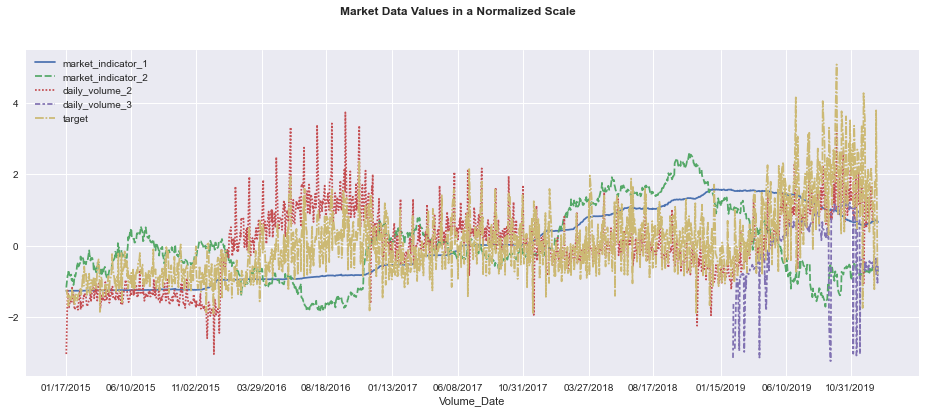

In [9]:
# 1. Plotting Market DF
mkt_plot(mkt_df)

In [10]:
# N/A percentage in mkt_df
display(mkt_df.isna().sum(0) / len(mkt_df))

daily_volume          0.000000
market_indicator_1    0.000000
market_indicator_2    0.000000
daily_volume_2        0.004835
daily_volume_3        0.821918
target                0.000806
dtype: float64

* Market Data ranges from 1/17/2015 to 12/31/2019
* *Daily Volume* displays a slight upward trend which implies the usage of autogressive model to account for past values.
* Normalized Daily Volume displays significant volatiilty. It has noticeable fluctuation with a modest increasing trend until the first half of 2019. It suddenly displays significantly higher upward trend starting from the second half of 2019.
* *Daily Volume 3* is not available until 2/11/2019. If *Daily Volume 3* does not have significant correlation with our target variable, *daily volume* then dropping it should be preferable.
* *Daily Volume 4* also has some missing values around 0.4\% of its total records. In this case we can extrapolate values to impute the missing values

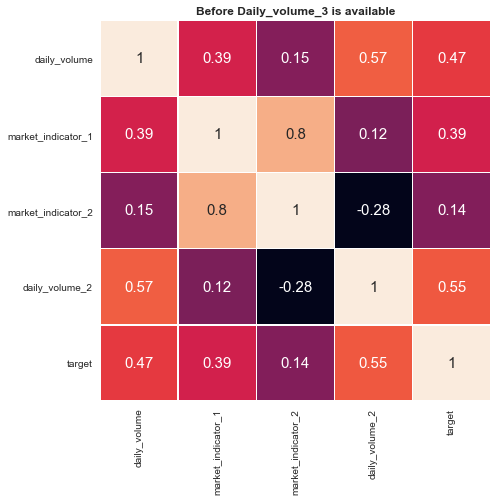

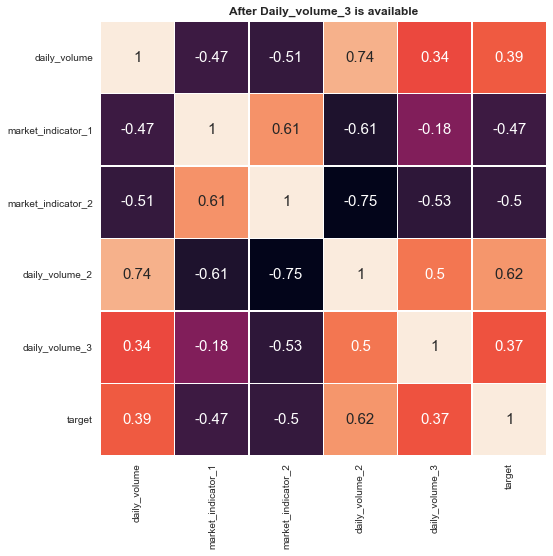

In [11]:
plot_mkt_corr(mkt_df)

* Looking at the far-right column, *daily_volume_3* has the smallest amount of absolute correlation with *daily_volume* and it has decent amount of linear correlation with the remaining variables. Therefore *daily_volume_3* will be dropped during the preprocessing step.

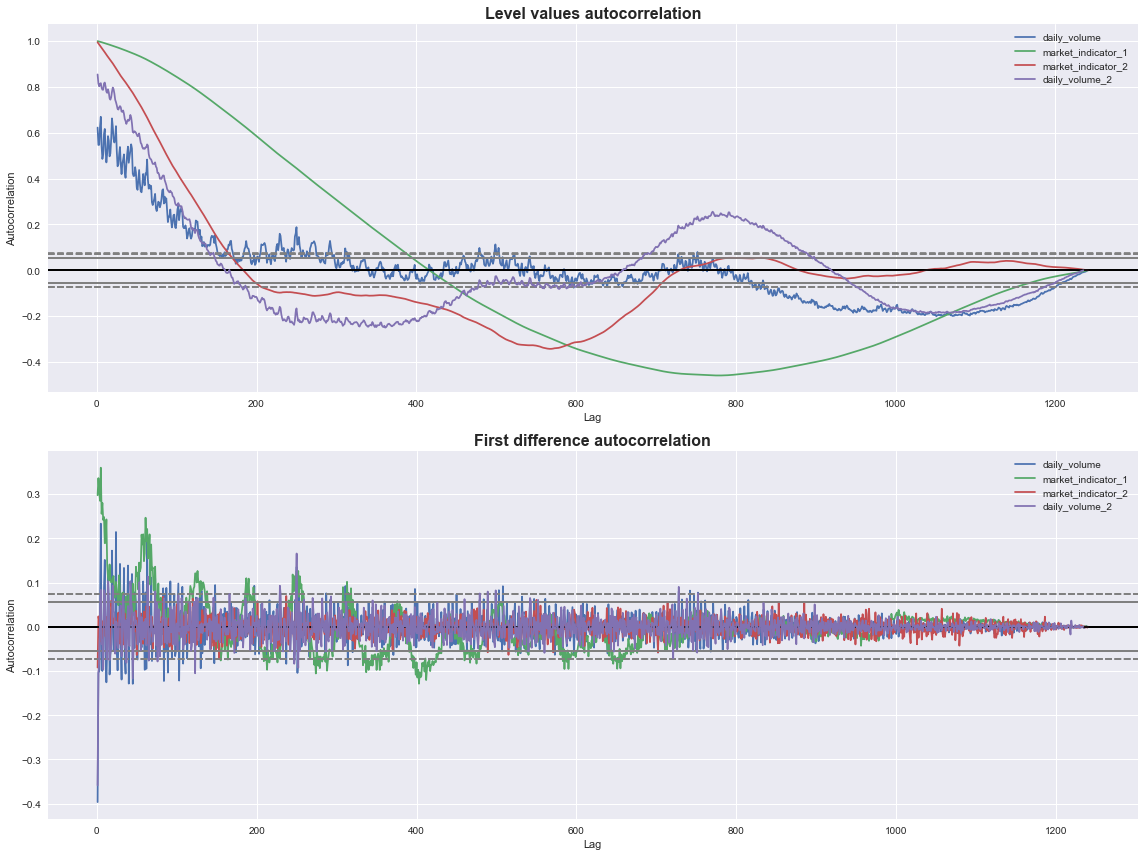

In [12]:
plot_autocorr(mkt_df)

* All the values from 'Market Data' exhibits autocorrelation over certain time period, mostly on a yearly basis with a lag of 240~250. 
* *Market Indicator 1* displays a long-term autocorrelation that spans around 800 business days.
* After taking the first differencing of each variables, all but *market_indicator_1* appear to be stationary

In [13]:
# Preprocess Dates Data
def process_date_df(date_data, cols_to_use=None):
    """
    Preprocess date dataframe by applying 'map_yes_no' and 'remove_constant' function
    Args
    ----
        date_data (pd.DataFrame): dataframe that contains date information
        cols_to_use (list): due to the variable drop that takes place in the initial phase,
                            we need to provide the list of columns to our test dataset
        
    Returns
    -------
        date_data (pd.DataFrame): dataframe after conducting step 1 and 2
    """
    if cols_to_use is None:
        date_data = (date_data.pipe(map_yes_no)
                              .pipe(remove_constant)
                              .pipe(remove_dup_dates)
        )
    else:
        date_data = (date_data.pipe(map_yes_no))
        date_data = date_data.loc[:, cols_to_use]
        
    return date_data

def map_yes_no(date_data):
    """
    Maps "Y" and "N" to 1, 0 respectively for date data and returns the updated dataframe.
    This function will be fed into the pipe method withint 'process_date_df' function
    """
    object_cols = (date_data.dtypes == 'object')
    date_data.loc[:, object_cols] = (date_data
                                    .select_dtypes(include='object')
                                    .applymap(lambda x: 1 if x=='Y' else 0)
                                    )
    return date_data


def remove_constant(date_data):
    """
    Identify columns whose values are constant i.e., std = 0
    Removes the constant columns and returns the updated dataframe
    """
    col_same = (date_data.describe().loc[['std']] == 0)
    date_data = date_data.loc[:, ~col_same.values.squeeze()]
    
    return date_data


def remove_dup_dates(date_data):
    """
    'drop_duplicates' works on row-wise comparison. Therefore transposing it makes duplicate
    comparison work on our variables.
    """
    date_data = date_data.T.drop_duplicates().T
    return date_data

In [14]:
# Preprocess Mkt data
def process_mkt_df(market_data):
    """
    Preprocess market dataframe by applying 'remove_na' and 'imputing_daily_vol_2' function
    Args
    ----
        market_data (pd.DataFrame): dataframe that contains date information
        
    Returns
    -------
        market_data (pd.DataFrame): dataframe after conducting step 1 and 2
    """
    market_data = (market_data.pipe(remove_na)
                              .pipe(add_past_vals)                   
                              .pipe(imputing_missing_values)
                    )
    
    return market_data
    
def remove_na(market_data):
    """
    Removes 'daily_volume_3' having too much missing values.
    Last row of the market_data is also removed by not having the target value.
    """
    market_data = market_data.drop(columns=['daily_volume_3'])
    market_data = market_data.iloc[:-1, :]
    
    return market_data


def imputing_missing_values(market_data):
    """
    'market_data.csv' has missing values in 'daily_volume_2' variable.
    The missing values are coming the fact that 'daily_volume_2' is not available at live.
    Will be using linear interpolation function to fill it in.
    
    'market_data' also has missing values arising from 'add_past_vals' function.
    Those will be imputed using minimum values.
    """
    # Interpolating Daily Volume 2
    market_data.loc[:, 'daily_volume_2'] = market_data.loc[:, 'daily_volume_2'].interpolate(method='linear')
    
    # Imputing moving averaged daily volume using minimum values
    yoy_na_loc = market_data['yoy_volume'].isna()
    qoq_na_loc = market_data['qoq_volume'].isna()
    
    yoy_min = market_data['yoy_volume'].min()
    qoq_min = market_data['qoq_volume'].min()
    
    market_data.loc[yoy_na_loc, 'yoy_volume'] = yoy_min
    market_data.loc[qoq_na_loc, 'qoq_volume'] = qoq_min
    
    return market_data


def add_past_vals(data, window_len=10):
    """
    For each date, fetch the previous yearly and quarterly value.
    Then apply moving average around those historical values to smooth out point estimation error.
    """
    data.loc[:, 'yoy_volume'] = (data['daily_volume']
                                    .shift(250) # shift 250 business days to get last year's volume
                                    .rolling(window_len) # rolling average to smooth out volume
                                    .mean())
    
    data.loc[:, 'qoq_volume'] = (data['daily_volume']
                                    .shift(60) # shift 250 business days to get last quarter's volume
                                    .rolling(window_len) # rolling average to smooth out volume
                                    .mean())
    
    return data

In [15]:
# Applies preprocessing and combine altogether for training
mkt_df = process_mkt_df(mkt_df)
date_df = process_date_df(date_df)

# Joins on the two data by having dates as the key which are used a index for both dataframe
comb_df = pd.merge(left=mkt_df,
                  right=date_df,
                  how='left',
                  left_index=True,
                  right_index=True)

In [16]:
# Train/Test Split
def train_test_split(combined_data, train_size=0.7, val_size=0.15, test_size=0.15):
    """
    Splits the combined dataframe into train(70%), validation(15%) and test(15%) data
    """
    train_idx = int(len(combined_data) * 0.7)
    val_idx = int(len(combined_data) * 0.85)
    train = combined_data.iloc[:train_idx, :]
    val =   combined_data.iloc[train_idx:val_idx, :]
    test =  combined_data.iloc[val_idx:, :]
    
    return train, val, test

In [17]:
train_df, val_df, test_df = train_test_split(comb_df)

## Model Fitting

In [18]:
# Functions to measure performance of a model
def scoring(model, validation_data, differenced=False):
    """
    Computes MSE, MAE, and directional movement of model's prediction against actual value.
    
    Args
    ----
    model: Fitted model supporting 'predict' method
    validation data (pd.DataFrame): dataframe that contains ground truth label
    
    Returns
    -------
    MSE, MAE, Directional Accuracy (Dict(float, float, float)): returns three metrics
    """
    X = validation_data.drop(columns=['target'])
    pred = pd.DataFrame(model.predict(X).squeeze(), 
                        index=validation_data.index, 
                        columns=['target'])
    #print(pred.head())
    MSE = mse(validation_data['target'], pred)
    MAE = mae(validation_data['target'], pred)
    
    target_direction = validation_data.target.diff() > 0
    pred_direction = pred['target'].diff() > 0
    assert len(target_direction) == len(pred_direction)
    direction_acc = np.mean(target_direction == pred_direction)
    
    return {'MSE': MSE, 'MAE':MAE, 'DIREC_ACC':direction_acc}

def plot_prediction(data, model, model_name) -> None:
    """
    Plots the model's prediction result with ground truth target value
    """
    target_arr = data.target
    X = data.drop(columns=['target'])
    pred = pd.DataFrame(model.predict(X), index=target_arr.index)
    plt.plot(target_arr, label='Target')
    plt.plot(pred, label=f'{model_name} Prediction')
    plt.legend()
    plt.title(f"Daily Volume against {model_name} Prediction", fontsize=14, fontweight='bold')
    plt.show()

    
def plot_nlag_acc(train_data, n_lag, kind) -> None:
    """
    Function used for ARIMA Fitting
    Plots the result of target variable after applying differencing 'n'times on the left ax.
    Autocorrelation is plotted on the right ax.
    'kind' determines whether partial autocorrelation(pacf) or autocorrelation(acf) will be plotted on the right ax.
    """
    differenced = (diff(train_data.target, k_diff=n_lag)
                  .dropna()
                  )
    _, axes = plt.subplots(1, 2, figsize=(18, 6))
    axes[0].plot(differenced)
    axes[0].set_title(f'{n_lag}th Differencing')
    if kind == 'pacf':
        plot_pacf(differenced, ax=axes[1])
    elif kind == 'acf':
        plot_acf(differenced, ax=axes[1])
    else:
        print("Kind should either be pacf or acf")
        return
    plt.show()

    
def plot_arima(data, arima_model) -> None:
    """
    Plots ARIMA model's forecast against ground truth daily_volume value
    """
    target_arr = data.target.diff().dropna()
    steps = len(target_arr)
    pred = pd.DataFrame(arima_model.forecast(steps), index=target_arr.index)
    plt.plot(target_arr, label='Target')
    plt.plot(pred, label='ARIMA')
    plt.legend()
    
    
def plot_all_metrics(test_data, ols_res, rf_res, xgb_res) -> None:
    """
    Given a test_data, calculates MSE, MAE and Directional Acc. for all 3 models and plots them 
    """
    ols_metrics = scoring(model=ols_res, validation_data=test_data)
    rf_metrics = scoring(model=rf_res, validation_data=test_data)
    xgb_metrics = scoring(model=xgb_res, validation_data=test_data)
    
    val_metrics = pd.DataFrame({'OLS': ols_metrics, 
                           'RF': rf_metrics,
                           'XGBoost': xgb_metrics}).T
    
    
    _, axes = plt.subplots(1, 3, figsize=(16, 6))

    for i, col in enumerate(val_metrics):
        val_metrics[col].plot(ax=axes[i], kind='bar')
        axes[i].set_title(col, fontweight='bold')

In [19]:
# Functions Used for Fitting OLS, ARIMA, Random Forest and XGBoost

## OLS##
def ols_fitting(train_data):
    formula = "target~" + "+".join(train_data.columns.drop(['target']).values)
    result = smf.ols(formula=formula, data=train_data).fit()
    print(result.summary())
    
    return result

##ARIMA##
def adf_test(timeseries) -> None:
    """
    Function to test stationarity and summarizes the result
    """
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

def arima_fitting(train_data, p=4, d=1, q=1):
    res = ARIMA(train_data.target.diff().dropna().values, order=(p, d, q)).fit()
    print(res.summary())
    
    return res

## Random Forest##
def random_forest_fitting(train_data, max_resources):
    """
    Conducts Hyper-parameter optimization using Randomized Hyperband on Random Forest Regressor.
    
    Args
    ----
    train_data (pd.DataFrame): data to train our random forest
    max_resources (int): budgets how many times the Hyperband will run in total.
    
    Returns
    -------
    search (CV Result): returns the result of CV
    best_model (estimator): best model found from fitting HalvingGridSearchCV
    """
    model = RandomForestRegressor()
    
    param_grid = {
        'max_depth': randint(3, 100),
        'min_samples_split': uniform()
    }
    
    tscv = TimeSeriesSplit(n_splits=5)
    
    X = train_data.drop(columns=['target'])
    y = train_data.loc[:, 'target']
    
    search = HalvingRandomSearchCV(model,
                                   param_grid,
                                   scoring='neg_mean_squared_error',
                                   cv=tscv,
                                   resource='n_estimators',
                                   max_resources=max_resources).fit(X, y)
    
    best_model = search.best_estimator_
    
    return search, best_model


## XGBoost ##
def xgboost_fitting(train_data, max_resources):
    """
    Conducts Hyper-parameter optimization using Randomized Hyperband on Random Forest Regressor.
    
    Args
    ----
    train_data (pd.DataFrame): data to train our random forest
    max_resources (int): budgets how many times the Hyperband will run in total.
    
    Returns
    -------
    search (CV Result): returns the result of CV
    best_model (estimator): best model found from fitting HalvingGridSearchCV
    """
    model = xgb.XGBRegressor(booster='gbtree')
    #xgbMatrix = xgb.DMatrix(data=train_data.drop(columns=[['target']]),
    #                        label=train_data['target'])
    
    param_grid = {
        'max_depth': randint(2, 5),
        'learning_rate': loguniform(0.001, 0.1),
        'reg_alpha': loguniform(0.1, 0.5),
    }
    
    tscv = TimeSeriesSplit(n_splits=5)
    
    X = train_data.drop(columns=['target'])
    y = train_data.loc[:, 'target']
    
    search = HalvingRandomSearchCV(model,
                                   param_grid,
                                   scoring='neg_mean_squared_error',
                                   cv=tscv,
                                   resource='n_estimators',
                                   max_resources=max_resources,
                                   verbose=1).fit(X, y)
    
    best_model = search.best_estimator_
    
    return search, best_model

### 1. OLS

In [20]:
ols_result = ols_fitting(train_df)

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.607
Method:                 Least Squares   F-statistic:                     50.55
Date:                Tue, 23 Mar 2021   Prob (F-statistic):          1.05e-155
Time:                        15:26:18   Log-Likelihood:                -7193.2
No. Observations:                 868   AIC:                         1.444e+04
Df Residuals:                     840   BIC:                         1.458e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

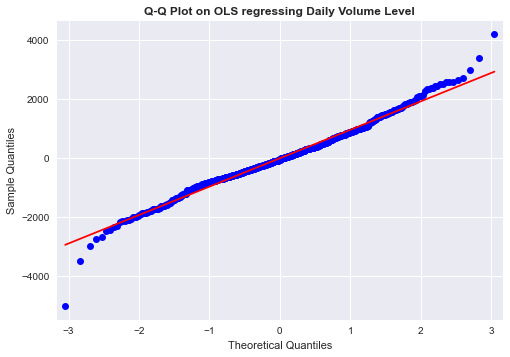

In [21]:
qqplot(ols_result.resid, line='s');
plt.title("Q-Q Plot on OLS regressing Daily Volume Level",
          fontdict={'fontweight':'bold'});

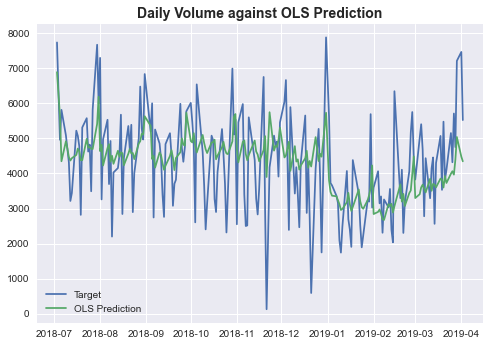

In [22]:
plot_prediction(val_df, ols_result, "OLS")

In [23]:
ols_metrics = scoring(model=ols_result, validation_data=val_df)
print(ols_metrics)

{'MSE': 1545033.4559373788, 'MAE': 981.5723070486348, 'DIREC_ACC': 0.532258064516129}


### Findings on OLS
- Q-Q Plot indicates **heavy tail** distribution of the residual which means residual does not follow normal distribution as OLS assumes to possess.
- Autocorrelation graph also suggests that residuals maybe **autocorrelated**. This suggest applying **ARIMA** to model behavior of 'daily_volume'
- Summary table of the OLS result warns existence of **multicollinearity**. This suggests usage of **variable selection** method or **regularization method**.

### 2. ARIMA
### 2-1 Finding order of integration using ADF test

In [24]:
print("Using Daily_Volume Level")
adf_test(train_df['target'])
print("\nUsing Daily_Volume First Difference")
adf_test(train_df['target'].diff().dropna())

Using Daily_Volume Level
Results of Dickey-Fuller Test:
Test Statistic                  -2.015842
p-value                          0.279671
#Lags Used                      21.000000
Number of Observations Used    846.000000
Critical Value (1%)             -3.438103
Critical Value (5%)             -2.864962
Critical Value (10%)            -2.568592
dtype: float64

Using Daily_Volume First Difference
Results of Dickey-Fuller Test:
Test Statistic                -1.664472e+01
p-value                        1.623216e-29
#Lags Used                     2.000000e+01
Number of Observations Used    8.460000e+02
Critical Value (1%)           -3.438103e+00
Critical Value (5%)           -2.864962e+00
Critical Value (10%)          -2.568592e+00
dtype: float64


* Our target variable, *daily_volume* becomes stationary after first difference -> **D=1**

### 2-2 AR(p) 

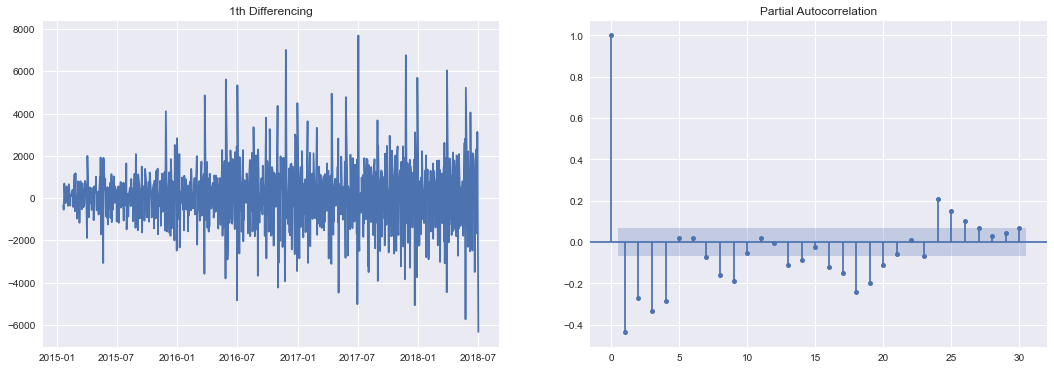

In [25]:
plot_nlag_acc(train_df, 1, 'pacf')

* Lag-1 partial autocorrelation becomes insignificant from lag-5. Therefore we can choose **AR(p=4)**
### 2-3 MA(q)

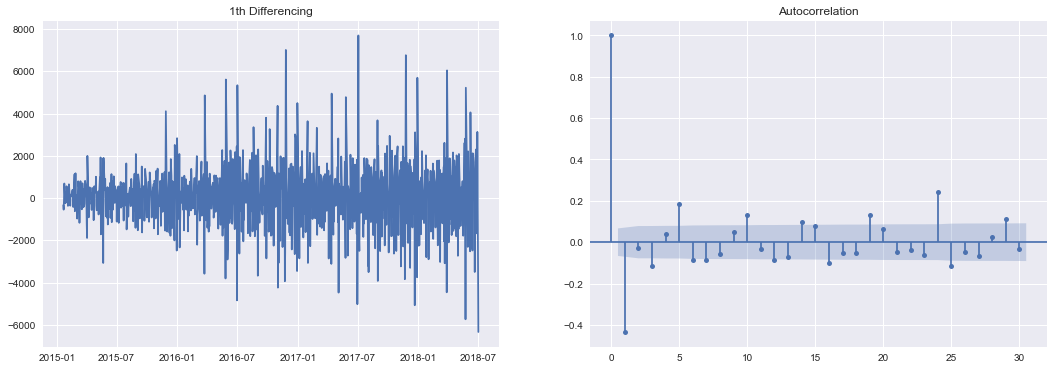

In [26]:
plot_nlag_acc(train_df, 1, 'acf')

* Autocorrelation displays a sharp cut-off after the first lag. Therefore we choose **MA(q=1)**

### 2-4 Fits ARIMA(p=4, d=1, q=1)

In [27]:
arima_result = arima_fitting(train_df)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  867
Model:                 ARIMA(4, 1, 1)   Log Likelihood               -7386.912
Date:                Tue, 23 Mar 2021   AIC                          14785.824
Time:                        15:26:21   BIC                          14814.407
Sample:                             0   HQIC                         14796.763
                                - 867                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7540      0.026    -29.252      0.000      -0.805      -0.703
ar.L2         -0.5997      0.034    -17.857      0.000      -0.666      -0.534
ar.L3         -0.5296      0.032    -16.681      0.0

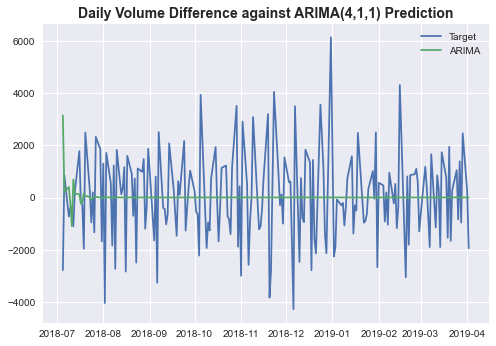

In [28]:
plt.title("Daily Volume Difference against ARIMA(4,1,1) Prediction", fontsize=14, fontweight='bold')
plot_arima(val_df, arima_result)

* ARIMA soon looses variance and outputs *difference* near 0. ARIMA(4,1,1) clearly does not fit the data well.
* We need models that are capable of handling year-to-year autocorrelation as well exogeneous variables
* Boosted Trees and Random Forest capable of handling multiple variables, interaction effects and non-linear relationship will be fitted in the following section
* In order to facilitate ML models learning year-to-year dependence, autocorrelation on a yearly basis will be added to our feature set

### 3. Random Forest using Successive Halving (a.k.a, Hyperband)

In [29]:
rf_search, rf_result = random_forest_fitting(train_df, args.train_epoch)

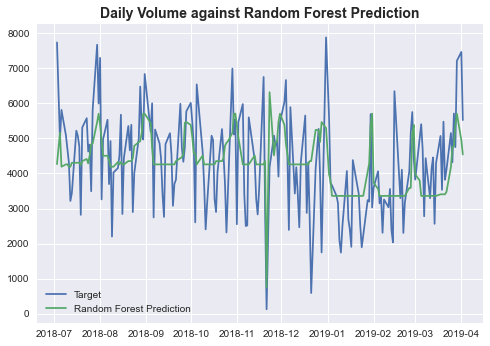

In [30]:
plot_prediction(val_df, rf_result, "Random Forest")

In [31]:
rf_metrics = scoring(model=rf_result, validation_data=val_df)
print(rf_metrics)

{'MSE': 1506024.7314872786, 'MAE': 975.9484827399334, 'DIREC_ACC': 0.532258064516129}


### XGBoost using Successive Halving

In [32]:
xgb_search, xgb_result = xgboost_fitting(train_df, args.train_epoch)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 1
max_resources_: 10
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 10
n_resources: 1
Fitting 5 folds for each of 10 candidates, totalling 50 fits
----------
iter: 1
n_candidates: 4
n_resources: 3
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 2
n_candidates: 2
n_resources: 9
Fitting 5 folds for each of 2 candidates, totalling 10 fits


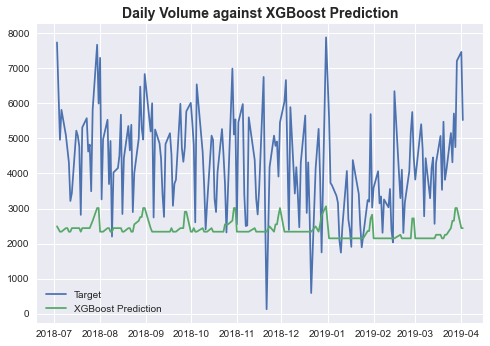

In [33]:
plot_prediction(val_df, xgb_result, "XGBoost")

In [34]:
xgb_metrics = scoring(model=xgb_result, validation_data=val_df)
print(xgb_metrics)

{'MSE': 5229092.29137792, 'MAE': 1940.0635211903561, 'DIREC_ACC': 0.5376344086021505}


## Final Report Summarizing Performances

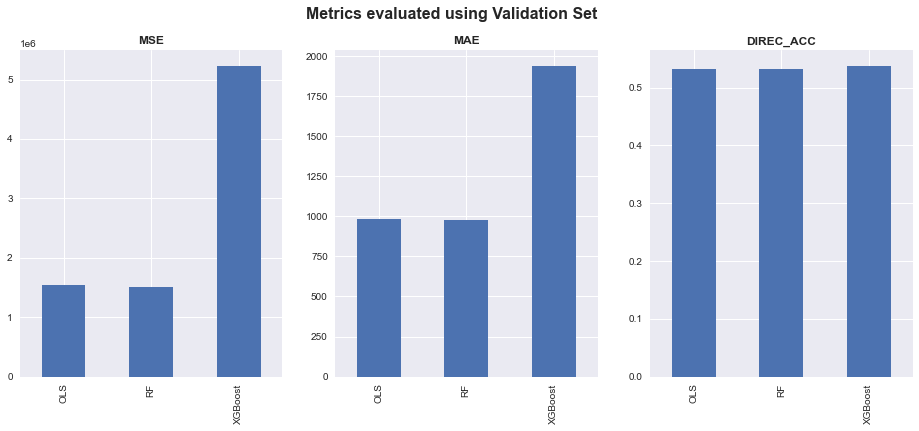

In [35]:
plot_all_metrics(val_df, ols_result, rf_result, xgb_result)
plt.suptitle("Metrics evaluated using Validation Set", fontsize=16, fontweight='bold');

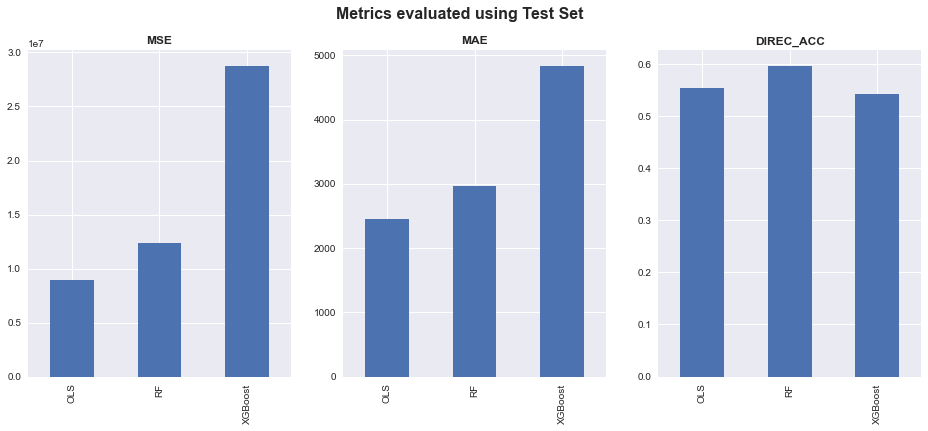

In [36]:
plot_all_metrics(test_df, ols_result, rf_result, xgb_result)
plt.suptitle("Metrics evaluated using Test Set", fontsize=16, fontweight='bold');

# Main function call output the prediction result

In [ ]:
if __name__ == '__main__':
    main()